In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Rreading train dataset
file_path = "./train.csv"
raw_data = pd.read_csv(file_path)
print("Data points count: ", raw_data['id'].count())
raw_data.head()

Data points count:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


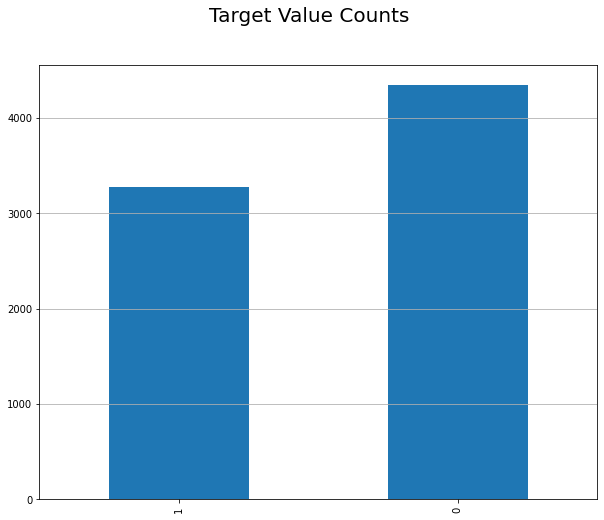

In [ ]:
# Plotting target value counts
plt.figure(figsize=(10,8))
ax = raw_data['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()

In [ ]:
print("Number of missing data for column keyword: ", raw_data['keyword'].isna().sum())
print("Number of missing data for column location: ", raw_data['location'].isna().sum())
print("Number of missing data for column text: ", raw_data['text'].isna().sum())
print("Number of missing data for column target: ", raw_data['target'].isna().sum())

Number of missing data for column keyword:  61
Number of missing data for column location:  2533
Number of missing data for column text:  0
Number of missing data for column target:  0


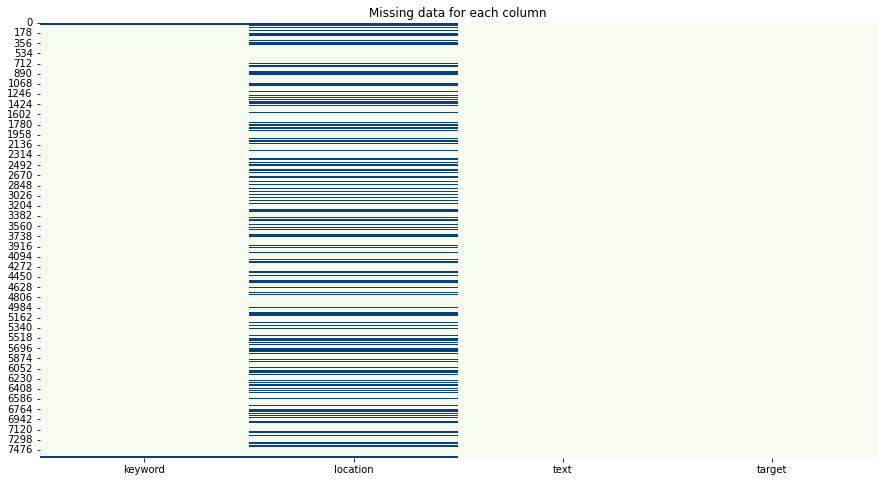

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(raw_data.drop('id', axis=1).isnull(), cbar=False, cmap="GnBu").set_title("Missing data for each column")
plt.show()

<ipython-input-7-169de689176d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_data['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


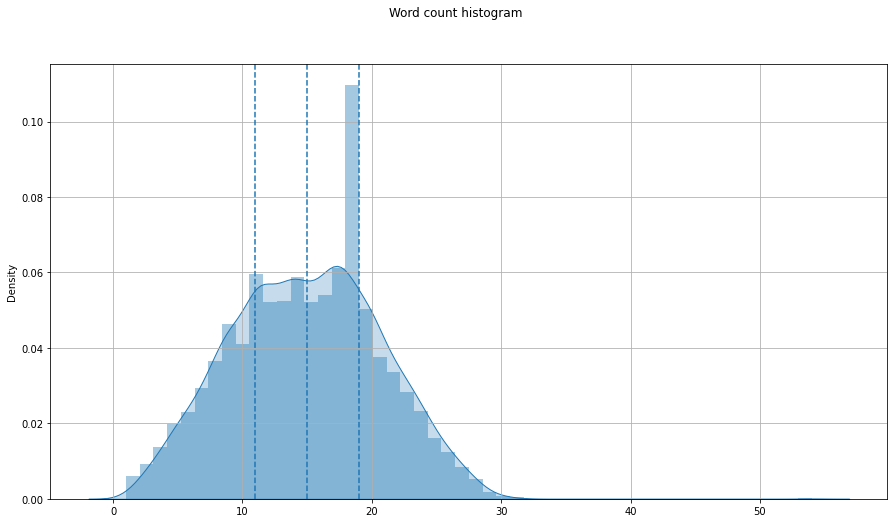

In [ ]:
plt.figure(figsize=(15,8))
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(raw_data['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(raw_data['word_count'].describe()['25%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['50%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['75%'], ls="--")

plt.grid()
plt.suptitle("Word count histogram")
plt.show()

# remove rows with under 3 words
raw_data = raw_data[raw_data['word_count']>2]
raw_data = raw_data.reset_index()

In [ ]:
print("25th percentile: ", raw_data['word_count'].describe()['25%'])
print("mean: ", raw_data['word_count'].describe()['50%'])
print("75th percentile: ", raw_data['word_count'].describe()['75%'])

25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


In [ ]:
import nltk
nltk.download('punkt')
# Clean text columns
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


def clean_text(each_text):

    # remove URL from text
    each_text_no_url = re.sub(r"http\S+", "", each_text)
    
    # remove numbers from text
    text_no_num = re.sub(r'\d+', '', each_text_no_url)

    # tokenize each text
    word_tokens = word_tokenize(text_no_num)
    
    # remove sptial character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
    
    return " ".join(" ".join(stemmed_text).split())


raw_data['clean_text'] = raw_data['text'].apply(lambda x: clean_text(x) )
raw_data['keyword'] = raw_data['keyword'].fillna("none")
raw_data['clean_keyword'] = raw_data['keyword'].apply(lambda x: clean_text(x) )
# Combine column 'clean_keyword' and 'clean_text' into one
raw_data['keyword_text'] = raw_data['clean_keyword'] + " " + raw_data["clean_text"]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
feature = 'keyword_text'
label = "target"

# split train and test
X_train, X_test,y_train, y_test = model_selection.train_test_split(raw_data[feature],
                                                                   raw_data[label],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)



Gradient Boosting Classifier

In [ ]:
X_train_GBC = X_train.values.reshape(-1)
x_test_GBC = X_test.values.reshape(-1)
# Vectorize text
vectorizer = CountVectorizer()
X_train_GBC = vectorizer.fit_transform(X_train_GBC)
x_test_GBC = vectorizer.transform(x_test_GBC)
# Train the model
model = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
model.fit(X_train_GBC, y_train)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features=8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=6,
                           min_weight_fraction_leaf=0.0, n_estimators=2000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
# Evaluate the model
predicted_prob = model.predict_proba(x_test_GBC)[:,1]
predicted = model.predict(x_test_GBC)

accuracy = metrics.accuracy_score(predicted, y_test)
print("Test accuracy: ", accuracy)
print(metrics.classification_report(y_test, predicted, target_names=["0", "1"]))
print("Test F-scoare: ", metrics.f1_score(y_test, predicted))

NameError: ignored

In [ ]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

In [ ]:
path_to_glove_file = './glove.6B.300d.txt' # download link: http://nlp.stanford.edu/data/glove.6B.zip
embedding_dim = 300
learning_rate = 1e-3
batch_size = 1024
epochs = 20
sequence_len = 100

In [ ]:
# Define train and test labels
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)

print("Training Y shape:", y_train_LSTM.shape)
print("Testing Y shape:", y_test_LSTM.shape)

Training Y shape: (5294, 1)
Testing Y shape: (2270, 1)


In [ ]:
# Tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  11148


In [ ]:
# Pad train and test 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=sequence_len)

print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_test.shape)

Training X shape:  (5294, 100)
Testing X shape:  (2270, 100)


In [ ]:
# Read word embeddings
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

FileNotFoundError: ignored

In [ ]:
# Define embedding layer in Keras
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)

In [ ]:
# Define model architecture
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          3344400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
# Optimize the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the LSTM Model
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

Epoch 1/20
6/6 [==============================] - 62s 9s/step - loss: 0.6930 - accuracy: 0.5654 - val_loss: 0.6927 - val_accuracy: 0.5767
Epoch 2/20
6/6 [==============================] - 50s 8s/step - loss: 0.6926 - accuracy: 0.5654 - val_loss: 0.6923 - val_accuracy: 0.5767
Epoch 3/20
6/6 [==============================] - 50s 8s/step - loss: 0.6923 - accuracy: 0.5654 - val_loss: 0.6918 - val_accuracy: 0.5767
Epoch 4/20
6/6 [==============================] - 56s 9s/step - loss: 0.6919 - accuracy: 0.5654 - val_loss: 0.6914 - val_accuracy: 0.5767
Epoch 5/20
6/6 [==============================] - 50s 8s/step - loss: 0.6916 - accuracy: 0.5654 - val_loss: 0.6910 - val_accuracy: 0.5767
Epoch 6/20
6/6 [==============================] - 59s 10s/step - loss: 0.6912 - accuracy: 0.5654 - val_loss: 0.6906 - val_accuracy: 0.5767
Epoch 7/20
6/6 [==============================] - 49s 8s/step - loss: 0.6909 - accuracy: 0.5654 - val_loss: 0.6903 - val_accuracy: 0.5767
Epoch 8/20
6/6 [=================

In [ ]:
# Plot train accuracy and loss
accuraties = history.history['acc']
losses = history.history['loss']
accuraties_losses = list(zip(accuraties,losses))

accuraties_losses_df = pd.DataFrame(accuraties_losses, columns={"accuraties", "losses"})

plt.figure(figsize=(10,4))
plt.suptitle("Train Accuracy vs Train Loss")
sns.lineplot(data=accuraties_losses_df)
plt.show()


KeyError: ignored

In [ ]:
# Evaluate the model
predicted = model.predict(X_test, verbose=1, batch_size=10000)

y_predicted = [1 if each > 0.5 else 0 for each in predicted]

score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)

print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

In [ ]:
# Plot confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()


Different Method

In [ ]:
!pip install --upgrade tensorflow
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from tifffile import imread
from wordcloud import WordCloud

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, LSTM, CuDNNLSTM, Embedding, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorf

In [ ]:
data_train = pd.read_csv('/content/train.csv');
data_test = pd.read_csv('/content/test.csv');

print(data_train.head(), '\n')
print(data_train.info(), '\n')
print(data_test.head(), '\n'),
print(data_test.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 

   id keyword location          

In [ ]:
data_train = data_train.drop(['keyword', 'location'], axis=1)
data_test = data_test.drop(['keyword', 'location'], axis=1)

print(data_train.head(), '\n')
print(data_test.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1 

   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


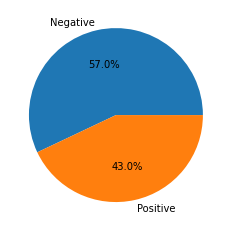

1.3274228064811984


In [ ]:
label_count = data_train['target'].value_counts()
labels = ['Negative', 'Positive']

plt.pie(label_count, labels=labels, autopct='%1.1f%%')

plt.show()

print(label_count[0] / label_count[1])

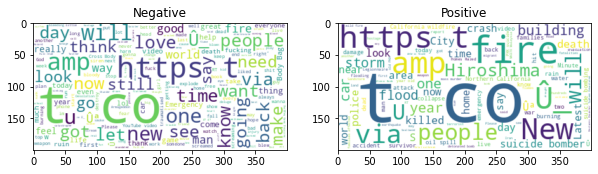

In [ ]:
negative_cases = "".join(data_train[data_train['target'] == 0]['text'].values)
positive_cases = "".join(data_train[data_train['target'] == 1]['text'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()


In [ ]:
data_train['text'] = data_train['text'].str.replace(r't|https|co|Û_', '', regex=True)
data_test['text'] = data_test['text'].str.replace(r't|https|co|Û_', '', regex=True)

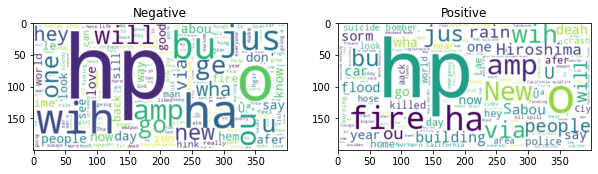

In [ ]:
negative_cases = "".join(data_train[data_train['target'] == 0]['text'].values)
positive_cases = "".join(data_train[data_train['target'] == 1]['text'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()

In [ ]:
sentences_train = data_train['text'].values
sentences_test = data_test['text'].values

In [ ]:
print(np.mean([len(text) for text in data_train['text']]))

print(data_train['text'][0])

print(len(data_train['text'][0]))

92.38368580060423
Our Deeds are he Reason of his #earhquake May ALLAH Forgive us all
66


In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(sentences_train)

sequences_train = tokenizer.texts_to_sequences(sentences_train)

# This is used for Embedding layer afterwards
num_words = len(tokenizer.word_index)

print(num_words)

maxlen_tokens = 20

# The reason that the maxlength is different than the true max length is that the texts are tokenized
padded_sequences_train = pad_sequences(sequences_train, maxlen=maxlen_tokens, padding='post', truncating='post')

padded_sequences_train[0]

22952


array([ 109, 4673,   22,    2,  848,    7,   19,  248,  130, 1620, 4674,
         86,   35,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
num_validation_samples = round(0.2 * len(padded_sequences_train))

seq_train = padded_sequences_train[num_validation_samples:]
labels_train = data_train['target'].values[num_validation_samples:]
seq_validate = padded_sequences_train[:num_validation_samples]
labels_validate = data_train['target'].values[:num_validation_samples]

print(len(seq_train))
print(len(seq_validate))

print(seq_train[0])
print(seq_train.shape)

6090
1523
[ 3240    17   131    51     2   241   201   147     7   175     8 10206
  2547  2332    30   292   515  1101   296     4]
(6090, 20)


In [ ]:
model_final = Sequential()

model_final.add(Embedding(num_words, 32, input_length=maxlen_tokens))

model_final.add(CuDNNLSTM(64, return_sequences=True))
model_final.add(BatchNormalization())

model_final.add(CuDNNLSTM(128))
model_final.add(BatchNormalization())

model_final.add(Dense(units=256, activation='relu'))
model_final.add(BatchNormalization())

model_final.add(Dense(units=1, activation='sigmoid'))

model_final.build(input_shape=(None, maxlen_tokens))

model_final.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 32)            734464    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 20, 64)            25088     
                                                                 
 batch_normalization (BatchN  (None, 20, 64)           256       
 ormalization)                                                   
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 128)               99328     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
opt_final = Adam(learning_rate=0.00001, decay=0.000001)

model_final.compile(optimizer=opt_final, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist_final = model_final.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=15)

Epoch 1/15


InvalidArgumentError: ignored

In [ ]:
plt.plot(hist_final.history["accuracy"])
plt.plot(hist_final.history['val_accuracy'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

NameError: ignored